In [1]:
# Initial installs and imports
# !pip install torch torchvision

import torch
print(f"torch version = {torch.__version__}")
torch.manual_seed(42)

import numpy as np
np.set_printoptions(precision=3)

torch version = 2.0.1


In [2]:
## lets create a dataloader for the dogs and cats dataset
from torch.utils.data import Dataset
from PIL import Image


class ImageDataset(Dataset):
    def __init__(self, file_list, labels, transform):
        self.file_list = file_list
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(self.file_list[index])
        if self.transform is not None:
            img = self.transform(img)

        label = self.labels[index]

        return img, label

    def __len__(self):
        return len(self.labels)


def get_label_list(file_list):
    labels = []
    for file in file_list:
        if "/dog." in file:
            labels.append(1)
        else:
            labels.append(0)

    return labels


In [3]:
import pathlib

## create the dataloader

## apply transformations
import torchvision.transforms as transforms
import torch.nn as nn

# gather the images
imgdir_path = pathlib.Path("../dogsncats/train/")
file_list = sorted([str(path) for path in imgdir_path.glob("*jpg")])

# desired image sizes from 500x374 to 125x94
img_width = 256
img_height = 192
rotation_angle = 30  # Specify the range of rotation angles in degrees

# Open an image

# create the transformer
transform = transforms.Compose(
    [
        transforms.Resize((img_height, img_width)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=rotation_angle),
        transforms.ToTensor(),
    ]
)

# create the data loader
catsndogsData = ImageDataset(file_list, get_label_list(file_list), transform)


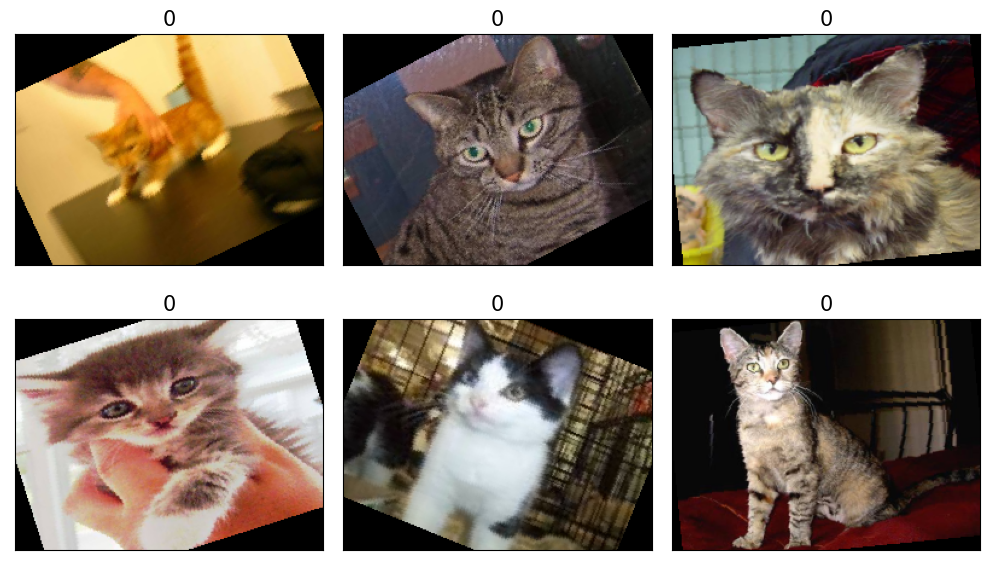

In [4]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 6))
for i, example in enumerate(catsndogsData):
    ax = fig.add_subplot(2, 3, i + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(example[0].numpy().transpose((1, 2, 0)))
    ax.set_title(f"{example[1]}", size=15)
    if i == 5:
        break

plt.tight_layout()
plt.show()


In [5]:
## define our CNN

model = nn.Sequential()
model.add_module(
    "conv1", nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2)
)
model.add_module("relu1", nn.ReLU())
model.add_module("pool1", nn.MaxPool2d(kernel_size=2))
model.add_module("dropout1", nn.Dropout(p=0.2))
model.add_module(
    "conv2", nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
)
model.add_module("relu2", nn.ReLU())
model.add_module("pool2", nn.MaxPool2d(kernel_size=2))
model.add_module("dropout2", nn.Dropout(p=0.2))
model.add_module("flatten", nn.Flatten())
model.add_module("fc1", nn.Linear(196608, 1024))
model.add_module("relu3", nn.ReLU())
model.add_module("dropout3", nn.Dropout(p=0.5))
model.add_module("fc2", nn.Linear(1024, 1))

criterion = nn.BCEWithLogitsLoss()
optim = torch.optim.Adam(model.parameters(), lr=0.001)


In [6]:
from torchsummary import summary

summary(model, (3, img_height, img_width))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 192, 256]           2,432
              ReLU-2         [-1, 32, 192, 256]               0
         MaxPool2d-3          [-1, 32, 96, 128]               0
           Dropout-4          [-1, 32, 96, 128]               0
            Conv2d-5          [-1, 64, 96, 128]          51,264
              ReLU-6          [-1, 64, 96, 128]               0
         MaxPool2d-7           [-1, 64, 48, 64]               0
           Dropout-8           [-1, 64, 48, 64]               0
           Flatten-9               [-1, 196608]               0
           Linear-10                 [-1, 1024]     201,327,616
             ReLU-11                 [-1, 1024]               0
          Dropout-12                 [-1, 1024]               0
           Linear-13                    [-1, 1]           1,025
Total params: 201,382,337
Trainable par

In [7]:
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler

# Define the indices to split the dataset
dataset_size = len(catsndogsData)
indices = list(range(dataset_size))
split = int(dataset_size * 0.8)  # 80% for training, 20% for validation
train_indices, val_indices = indices[:split], indices[split:]

# Define samplers for train and validation sets
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# Create data loaders for train and validation sets
train_loader = DataLoader(catsndogsData, batch_size=64, sampler=train_sampler)
val_loader = DataLoader(catsndogsData, batch_size=64, sampler=val_sampler)


In [8]:
import time

# define the training and validation loops
def train(
    model,
    num_epochs,
    train_loader,
    val_loader,
    train_accuracy_list,
    val_accuracy_list,
    save_weight_path,
    starting_epoch=0,
    weight_file_path=None,
):

    if starting_epoch != 0 and weight_file_path is not None:
        model.load_state_dict(torch.load(weight_file_path))
    else:
        if starting_epoch != 0:
            raise Exception("sorry you must provide a path to your weight_file")

    # Training loop
    model.train()
    for epoch in range(starting_epoch, num_epochs + starting_epoch):
        print(f"Epoch {epoch + 1}/{num_epochs+starting_epoch}")
        print("[" + "-" * 20 + "]")  # Initial empty progress bar

        total_steps = len(train_loader)
        for step, (inputs, labels) in enumerate(train_loader):

            labels = labels.float()

            # Forward pass
            outputs = model(inputs).float().squeeze()

            # Compute loss
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optim.zero_grad()
            loss.backward()
            optim.step()

            # Update progress bar
            pbar.update(1)

            # Save model weights
            torch.save(
                model.state_dict(),
                f"{save_weight_path}/model_weights_epoch{epoch+1}.pt",
            )

        print()  # Move to the next line after the progress bar

        # Validation loop
        model.eval()
        with torch.no_grad():
            total_correct = 0
            total_samples = 0

            for inputs, labels in val_loader:

                # Forward pass
                outputs = model(inputs).float().squeeze()

                ##predictions
                # Define the sigmoid activation function
                sigmoid = nn.Sigmoid()

                # Apply sigmoid activation to the logits
                probabilities = sigmoid(outputs)

                # Set a threshold to determine the class assignment
                threshold = 0.5
                predictions = probabilities >= threshold

                # Update counts
                total_samples += labels.size(0)
                total_correct += (predictions == labels).sum().item()

            # Compute validation accuracy
            val_accuracy = total_correct / total_samples
            val_accuracy_list.append(val_accuracy)

            # Print validation accuracy for the epoch
            print(f"Epoch {epoch + 1}: Validation Accuracy = {val_accuracy:.4f}")

        model.train()  # Switch back to training mode

        # Compute train accuracy for the epoch
        total_correct = 0
        total_samples = 0

        for inputs, labels in train_loader:

            # Forward pass
            outputs = model(inputs).float().squeeze()

            ##predictions
            # Define the sigmoid activation function
            sigmoid = nn.Sigmoid()

            # Apply sigmoid activation to the logits
            probabilities = sigmoid(outputs)

            # Set a threshold to determine the class assignment
            threshold = 0.5
            predictions = probabilities >= threshold

            # Update counts
            total_samples += labels.size(0)
            total_correct += (predictions == labels).sum().item()

        # Compute train accuracy
        train_accuracy = total_correct / total_samples
        train_accuracy_list.append(train_accuracy)
        print(f"training accuracy: {train_accuracy}")


In [9]:
# TRAIN
num_epochs = 30
load_weight_path = pathlib.Path("dogsncats/model_weights/model_weights_epoch49.pt")
save_weight_path = pathlib.Path("../dogsncats/model_weights/")

# train(model, num_epochs, train_loader, val_loader, train_accuracy_list, val_accuracy_list, starting_epoch=34, weight_file_path='../dogsncats/model_weights/model_weights_epoch34.pt', save_weight_path=save_weight_path)
